# SUBMITTED TO :
    MR. RAMAN SINGH

# SUBMITTED BY : 
  DIPTI KAUSHAL   101803601                                                                
    MANPREET KAUR    101803562                                                             
    
  SUNIDHI SINGLA   101983052
                                                                         

In this notebook, we have made an attempt to get a simple text classification model up and running. In this, amazon fine food review data from Kaggle (Link for the dataset-https://www.kaggle.com/simonerossi/sentiment-analysis-on-fine-food-reviews)

#                                                  SENTIMENT ANALYSIS

### Importing all the Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer
import string

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading Dataset

In [ ]:

df=pd.read_csv('Reviews.csv')
print(df.head())
df['sentiment'] = np.where(df.Score>3, 1,np.where(df.Score<3, -1,0))
df.rename(columns={'Text': 'review'}, inplace=True)
df=df[["review","sentiment"]]
print(df.sentiment.value_counts())
df


   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]
 1    443777
-1     82037
 0     42640
Name: sentiment, dtype: int64


,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,-1
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,-1
4,Great taffy at a great price. There was a wid...,1
...,...,...
568449,Great for sesame chicken..this is a good if no...,1
568450,I'm disappointed with the flavor. The chocolat...,-1
568451,"These stars are small, so you can give 10-15 o...",1
568452,These are the BEST treats for training and rew...,1


# Handling Missing Values

In [ ]:
#Finding if there is any row with NULL value
print("Total Samples which do not have reviews: ",len(df[df["review"]==None]))
print("Total Samples which do not have sentiments: ",len(df[df["sentiment"]==None]))
#If there is any missing value then drop that row
df.dropna(inplace=True)
df


Total Samples which do not have reviews:  0
Total Samples which do not have sentiments:  0


,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,-1
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,-1
4,Great taffy at a great price. There was a wid...,1
...,...,...
568449,Great for sesame chicken..this is a good if no...,1
568450,I'm disappointed with the flavor. The chocolat...,-1
568451,"These stars are small, so you can give 10-15 o...",1
568452,These are the BEST treats for training and rew...,1


# Undersampling

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


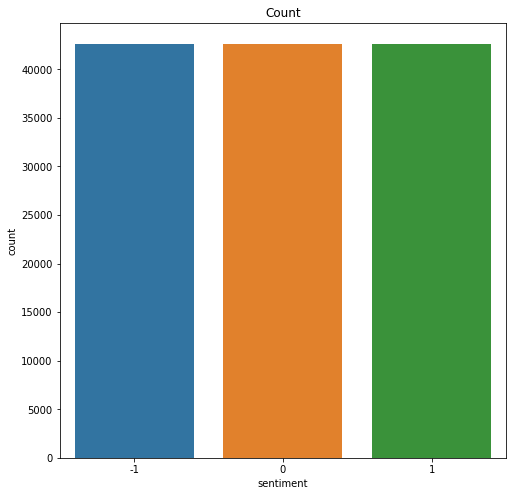

-1    42640
 1    42640
 0    42640
Name: sentiment, dtype: int64


In [ ]:

shuffled_df = df.sample(frac=1,random_state=4)
df1 = shuffled_df.loc[shuffled_df['sentiment'] == 0]
df1_temp = shuffled_df.loc[shuffled_df['sentiment'] == 1].sample(n=42640,random_state=42)
df2_temp = shuffled_df.loc[shuffled_df['sentiment'] == -1].sample(n=42640,random_state=42)

normalized_df = pd.concat([df1_temp,df1,df2_temp])

plt.figure(figsize=(8, 8))
sns.countplot('sentiment', data=normalized_df)
plt.title('Count')
plt.show()
df=normalized_df
print(df.sentiment.value_counts())

In [ ]:
#Mapping positive to 1 and negative to -1 and neutral to 0

df.loc[df['sentiment'] == 1, 'sentiment'] = "positive"
df.loc[df['sentiment'] == -1, 'sentiment'] = "negative"
df.loc[df['sentiment'] == 0, 'sentiment'] = "neutral"
df


,review,sentiment
81929,This is a great spicy rub. I made a bbq briske...,positive
85936,Pelindaba Lavender and honey is the perfect co...,positive
38429,"We rate this right up with high""er"" quality se...",positive
467610,I love these and have purchased several orders...,positive
537312,I am a subscriber to these bars because they a...,positive
...,...,...
547246,Thought I give the Blueberry a try after reall...,negative
336246,I read that chicken jerky from China is danger...,negative
340093,My dog has severe allergies as well as a sensi...,negative
358500,I bought this steak for my father in law for C...,negative


### Data Cleaning 

In [ ]:
#Data Cleaning
def process_string(text): 
   
    text = re.sub(r"https:\/\/.*[\r\n]*","",text) #remove any urls from the text
    text = re.sub(r"www\.\w*\.\w\w\w","",text)    #remove any urls starting from www. in the text
    text = re.sub(r"<[\w]*[\s]*/>","",text)       #remove any html elements from the text
    text = re.sub(r"[\.]*","",text)               #remove prediods  marks
    text= re.sub('[0-9\n]',' ',text)              # Remove numbers
    text = re.sub(r"[,.;@#?!&$_]+\ *", " ", text) #Remove special character
   
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)   #initilze tweet tokenizer    
    text_tokens = tokenizer.tokenize(text)          #tokenize text
    porter_stemmer = PorterStemmer()                #intizlize porter stemmer
    english_stopwords = stopwords.words("english")  #get english stopwords
    english_stopwords.remove('not')
    temp = ["br","href", 'http', 'just', 'amazon', 'product','time','year', 'tried','i\'ve']
    english_stopwords.extend(temp)
    cleaned_text_tokens = []                        # a list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and #remove stopwords
            (word not in string.punctuation)): #remove punctuation marks
                
                stemmed_word = porter_stemmer.stem(word) #get stem of the current word
                cleaned_text_tokens.append(stemmed_word) #appened stemmed word to list of cleaned list
    
    #combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

df["review"] = df["review"].apply(process_string)
df

,review,sentiment
81929,great spici rub made bbq brisket combin smokie...,positive
85936,pelindaba lavend honey perfect combin heavenli...,positive
38429,rate right high er qualiti sea salt strong fla...,positive
467610,love purchas sever order last year oz size rig...,positive
537312,subscrib bar delici healthi love snack need qu...,positive
...,...,...
547246,thought give blueberri tri realli enjoy dri cr...,negative
336246,read chicken jerki china danger dog look anoth...,negative
340093,dog sever allergi well sensit stomach thousand...,negative
358500,bought steak father law christma alway want tr...,negative


# Word Cloud after Data Cleaning

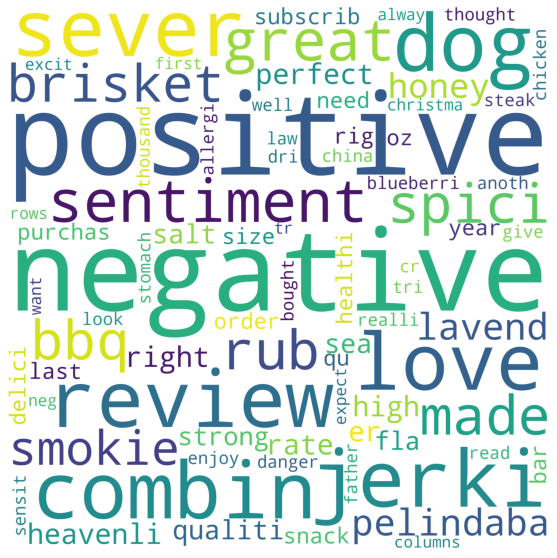

In [ ]:
#After Cleaning and Preprocessing, lets make a Word Cloud
wordcloud = WordCloud( background_color="white",width=2000,height=2000, max_words=2000).generate(str(df))
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

### Count Vectorization

In [ ]:
#Bag of Words
vect=CountVectorizer()
X=vect.fit_transform(df.review)
print(X.shape)
#print(X.toarray()) #We were unable to print X.toarray() because of its LARGE size

(127920, 85325)


### Tf-Idf

In [ ]:
vectorizer = TfidfVectorizer()  #term frequency–inverse document frequency
X = vectorizer.fit_transform(df.review)
print(vectorizer.get_feature_names())
print(X)

['aa', 'aaa', 'aaaaaaccckkk', 'aaah', 'aaahhh', 'aaalll', 'aaarrrggghhh', 'aachen', 'aacut', 'aadmit', 'aafco', 'aah', 'aain', 'aamzonhowev', 'aand', 'aani', 'aap', 'aar', 'aardvark', 'aaron', 'aaround', 'aasanfoodcom', 'aauc', 'ab', 'aback', 'abalon', 'abando', 'abandon', 'abandonedterr', 'abandonedw', 'abandonor', 'abat', 'abba', 'abbay', 'abbazabba', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abctoy', 'abd', 'abdomen', 'abdomin', 'abe', 'abel', 'aberr', 'aberrationunlik', 'abet', 'abhor', 'abhorr', 'abhorwould', 'abid', 'abiet', 'abil', 'abit', 'abject', 'abjectli', 'abl', 'able', 'ablecon', 'ableth', 'ableto', 'ableultim', 'ablt', 'abnorm', 'abnormalitiesmi', 'abod', 'aboiut', 'abold', 'abolitionist', 'abolut', 'abomin', 'abon', 'aboout', 'abort', 'abosolut', 'abosrb', 'abot', 'aboth', 'abottl', 'aboug', 'abouit', 'abound', 'about', 'abouta', 'aboutbut', 'aboutcom', 'abouteveri', 'aboutfirst', 'aboutfor', 'aboutgreat', 'abouth', 'abouthi', 'abouti', 'aboutit', 'aboutlauri', 'abo

# Training and testing data

In [ ]:
#Splitting to training and testing
tfidf_train,tfidf_test,sentiment_values_train,sentiment_values_test=train_test_split(X,df.sentiment,test_size=0.20,random_state=0)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score      
from sklearn.model_selection import StratifiedKFold             
from sklearn import metrics        
from sklearn.ensemble import RandomForestClassifier    
from sklearn.naive_bayes import BernoulliNB     
from sklearn.naive_bayes import GaussianNB     
from sklearn.naive_bayes import MultinomialNB   
from sklearn.tree import DecisionTreeClassifier                        
kfold = StratifiedKFold(n_splits=12) 
max_f1score=0
model_name=''

# Logistic Regression

Cross Validation Scores                : [0.72854128 0.72361632 0.71845685 0.72818949 0.71693246 0.7314728
 0.73123827 0.72115385 0.71916041 0.73182458 0.7347561  0.72830675]
Mean of Cross Validation score         : 72.61374296435271
Classification Report: 
               precision    recall  f1-score   support

    negative       0.74      0.74      0.74      8624
    positive       0.66      0.65      0.66      8529
     neutral       0.78      0.80      0.79      8431

    accuracy                           0.73     25584
   macro avg       0.73      0.73      0.73     25584
weighted avg       0.73      0.73      0.73     25584

Confusion Matrix                       :
 [[6350 1687  587]
 [1708 5568 1253]
 [ 549 1176 6706]]
The accuracy of the Logistic Regression: 72.79549718574108
The f1_score of the Logistic Regression: 72.82280769004346


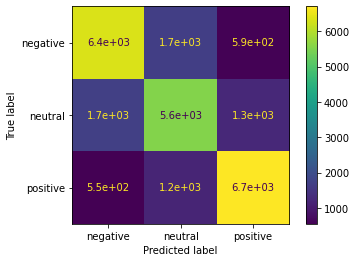

In [ ]:
                                   
lr = LogisticRegression(random_state=0, C=0.82286, max_iter=2000)                                
cv = cross_val_score(lr,tfidf_train,sentiment_values_train,cv=kfold)                                               
print("Cross Validation Scores                :",cv)
print("Mean of Cross Validation score         :",cv.mean()*100)
lr.fit(tfidf_train,sentiment_values_train)                                                                          
sentiment_values_pred_lr=lr.predict(tfidf_test)    
report=classification_report(sentiment_values_test, sentiment_values_pred_lr,target_names=['negative','positive','neutral'])    
print("Classification Report: \n",report)    
f1=metrics.f1_score(sentiment_values_pred_lr,sentiment_values_test,average='weighted')*100
cm=confusion_matrix(sentiment_values_test, sentiment_values_pred_lr)                                                         
print("Confusion Matrix                       :\n",cm)
print('The accuracy of the Logistic Regression:',metrics.accuracy_score(sentiment_values_pred_lr,sentiment_values_test)*100)    
print('The f1_score of the Logistic Regression:',f1)         
plot_confusion_matrix(lr,tfidf_test , sentiment_values_test) 
plt.show()
if(f1>max_f1score):
    max_f1score=f1
    model_name=LogisticRegression

# Random Forest Classifier

In [ ]:

rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,                            
                        min_samples_leaf=2,n_estimators=500, random_state=0)
rf.fit(tfidf_train, sentiment_values_train)
cv = cross_val_score(rf,tfidf_train,sentiment_values_train,cv=kfold)
print("Cross Validation Scores                   :",cv)
print("Mean of Cross Validation score            :",cv.mean()*100)
y_pred_rf = rf.predict(tfidf_test)
cm=confusion_matrix(sentiment_values_test, y_pred_rf)
f1=metrics.f1_score(y_pred_rf,sentiment_values_test,average='weighted')*100
print("Confusion Matrix                          :\n",cm)
print('The accuracy of the RandomForestClassifier:',metrics.accuracy_score(y_pred_rf,sentiment_values_test)*100)
print('The f1 score of the RandomForestClassifier:',f1)
print("\n",metrics.classification_report(y_pred_rf,sentiment_values_test))
plot_confusion_matrix(rf,tfidf_test , sentiment_values_test) 
plt.show()
if(f1>max_f1score):
    max_f1score=f1
    model_name=RandomForestClassifier

## Bernoulli Naive Bayes

Bernoulli Naive Bayes 

Classification Report: 
               precision    recall  f1-score   support

    negative       1.00      0.25      0.40         4
    positive       0.00      0.00      0.00         2
     neutral       0.74      1.00      0.85        14

    accuracy                           0.75        20
   macro avg       0.58      0.42      0.42        20
weighted avg       0.72      0.75      0.67        20

Confusion Matrix: 
 [[ 1  0  3]
 [ 0  0  2]
 [ 0  0 14]]
Accuracy: 
 0.75
F1 score: 
 0.6739393939393938


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


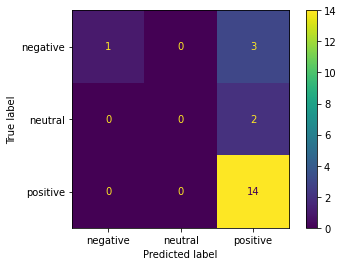

In [ ]:
print("Bernoulli Naive Bayes \n")

model_nb = BernoulliNB()
model_nb.fit(tfidf_train, sentiment_values_train)
predict=model_nb.predict(tfidf_test)
report=classification_report(sentiment_values_test, predict,target_names=['negative','positive','neutral'])
print("Classification Report: \n",report)      
matrix=confusion_matrix(sentiment_values_test, predict)
print("Confusion Matrix: \n",matrix)
accuracy=accuracy_score(sentiment_values_test, predict)    
print("Accuracy: \n", accuracy)

f1score=f1_score(sentiment_values_test, predict,average='weighted')
print ("F1 score: \n", f1score)                          
plot_confusion_matrix(model_nb,tfidf_test , sentiment_values_test)   
plt.show()                                                         
if(f1score>max_f1score):
    max_f1score=f1score
    model_name=BernoulliNB

# MultinomialNB

In [ ]:
mnb = MultinomialNB(alpha=2)
cv = cross_val_score(mnb,tfidf_train,sentiment_values_train,cv=kfold)
print("Cross Validation Scores                :",cv)
print("Mean of Cross Validation score         :",cv.mean()*100)
mnb.fit(tfidf_train,sentiment_values_train)
y_pred_mnb=mnb.predict(tfidf_test)
cm=confusion_matrix(sentiment_values_test, y_pred_mnb)
f1score=metrics.f1_score(y_pred_mnb,sentiment_values_test,average='weighted')*100
print("Confusion Matrix                       :\n",cm)
print('The accuracy of the Naive Bayes        :', metrics.accuracy_score(y_pred_mnb,sentiment_values_test)*100)
print('The f1 score of the Naive Bayes        :', f1score)
print("\n",metrics.classification_report(y_pred_mnb,sentiment_values_test))
plot_confusion_matrix(model_nb,tfidf_test , sentiment_values_test)   
plt.show()                                                         
if(f1score>max_f1score):
    max_f1score=f1score
    model_name=MultinomialNB

## Decision Tree Classifier

Decision Tree 

Classification Report: 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
    positive       0.00      0.00      0.00         2
     neutral       0.69      0.79      0.73        14

    accuracy                           0.55        20
   macro avg       0.23      0.26      0.24        20
weighted avg       0.48      0.55      0.51        20

Confusion Matrix: 
 [[ 0  1  3]
 [ 0  0  2]
 [ 0  3 11]]
Accuracy: 
 0.55
F1 score: 
 76.45833333333334


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


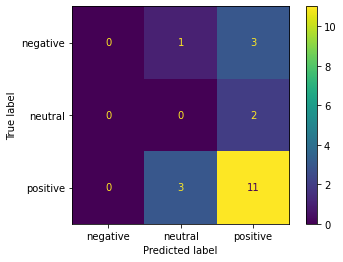

In [ ]:
#Decision Tree Classifier
print('Decision Tree \n')

maximum_tree_depth= 15
model_dt = DecisionTreeClassifier(max_depth=maximum_tree_depth)
model_dt.fit(tfidf_train,sentiment_values_train)
predict = model_dt.predict(tfidf_test)
report=classification_report(sentiment_values_test, predict,target_names=['negative','positive','neutral'])
print("Classification Report: \n",report)                  
matrix=confusion_matrix(sentiment_values_test, predict)
print("Confusion Matrix: \n",matrix)
accuracy=accuracy_score(sentiment_values_test, predict)   
print("Accuracy: \n", accuracy)
f1=f1_score(sentiment_values_test,predict,average='micro')
print ("F1 score: \n", f1score)                          
plot_confusion_matrix(model_dt,tfidf_test , sentiment_values_test)    
plt.show() 
if(f1score>max_f1score):
    max_f1score=f1
    model_name=DecisionTreeClassifier

#### Finding Best among above all Discussed Models 

In [ ]:
print('Max F1_score is of following model')
print('F1-Score=',max_f1score,'\nModel name : ',model_name)

Max F1_score is of following model
F1-Score= 82.35294117647058 
Model name :  <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [ ]:
#MODEL TESTING
newreview = "Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as Jumbo."
def prediction(text):   
        
    text = re.sub(r"https:\/\/.*[\r\n]*","",text)  
    text = re.sub(r"www\.\w*\.\w\w\w","",text)   
    text = re.sub(r"<[\w]*[\s]*/>","",text)
    text = re.sub(r"[\.]*","",text)
    text= re.sub('[0-9\n]',' ',text)
    text = re.sub(r"[,.;@#?!&$_]+\ *", " ", text)
   
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    text_tokens = tokenizer.tokenize(text)
    porter_stemmer = PorterStemmer()

    english_stopwords = stopwords.words("english")
    english_stopwords.remove('not')
    temp = ["br","href", 'http', 'just', 'amazon', 'product','time','year', 'tried','I\'ve']
    english_stopwords.extend(temp)
    cleaned_text_tokens = [] 
    
    for word in text_tokens:
        if((word not in english_stopwords) and 
            (word not in string.punctuation)): 
                
                stemmed_word = porter_stemmer.stem(word) 
                cleaned_text_tokens.append(stemmed_word)
    clean_text = " ".join(cleaned_text_tokens)
    clean_text =[clean_text]
    clean_text = vectorizer.transform(clean_text).toarray() 
    if lr.predict(clean_text)[0] == 1:
            return "positive"   
    else:       
            return "negative"

feedback = prediction(newreview)

print("This review is: ", feedback)

This review is:  negative
